**Chapter 7 – Ensemble Learning and Random Forests**

_This notebook contains all the sample code and solutions to the exercises in chapter 7._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

Chat gpt helped with this

# Setup

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_blobs
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigs
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Returns X and y data for the given number of dimensions
def get_dataset(n):
    return make_blobs(n_samples=100, centers=[[0]*n, [3]*n], n_features=n, random_state=42)
    # 4 works for 2D

In [ ]:
from sklearn.datasets import make_circles
import numpy as np
from sklearn.datasets import make_blobs

def get_concave_dataset(n, size):
  if (n==1): 
    # Alternating points
    X = np.arange(size)
    y = X%2
    X = X.reshape(-1, 1)
    # [1, 2, 3, 4].shape = (4,)
    # [[1], [2], [3], [4]].shape = (4, 1)
    # print(X.shape, y.shape)

  if (n == 2):
    # Concentric circles
    X, y = make_circles(n_samples=size, noise=0.1, factor=0.05, random_state=42)
  
  if (n == 3):
    #concentric spheres
    # Generate data
    centers = [(0, 0, 0), (0, 0, 0)]
    cluster_std = [0.5, 1.5]
    X, y = make_blobs(n_samples=size, centers=centers, cluster_std=cluster_std, random_state=42)

    # Create two concentric spheres from the clusters
    X_inner = X[y == 0] / np.max(np.abs(X), axis=0) * 0.5
    X_outer = X[y == 1] / np.max(np.abs(X), axis=0) * 1.5
    X = np.vstack([X_inner, X_outer])
    y = np.hstack([np.zeros(X_inner.shape[0]), np.ones(X_outer.shape[0])])

    # Shuffle data
    shuffle_idx = np.random.permutation(size)
    X = X[shuffle_idx]
    y = y[shuffle_idx]


  return X, y

In [ ]:
# Plot 1d, d2, or 3d data
def plot(X, y, title):
    data = list(X.T)
    if len(data) == 1:
        data.append(np.zeros_like(data[0]))
    ax = plt.subplot(111, projection=('3d' if len(data) == 3 else None))
    ax.scatter(*data, c=y)
    plt.title(title)
    plt.show()

In [ ]:
import cvxpy as cp

def goemans_williamson_bad(input, random_state=0):
  # Set random seed
  np.random.seed(random_state)

  # Get graph edges
  n = len(input)
  
  edges = [(i, j) for i in range(n) for j in range(n) if ((input[i] - input[j])**2).sum() <= threshold]
  # graph = kneighbors_graph(input, n_neighbors=2, mode='distance')
  # edges = list(zip(np.arange(n).repeat(2), graph.indices))

  # Create constraint problem
  X = cp.Variable((n,n), symmetric=True)
  constraints = [X >> 0]
  constraints += [X[i,i] == 1 for i in range(n)]
  objective = sum(0.5*(1 - X[i, j]) for (i, j) in edges)
  prob = cp.Problem(cp.Maximize(objective), constraints)
  prob.solve()

  # Partition with random hyperplane
  u = np.random.randn(n)
  labels = np.where((sqrtm(X.value) @ u) >= 0, 1, 0)
  return labels

In [ ]:
import cvxpy as cp
from scipy.spatial.distance import cdist

def goemans_williamson(input, iters=1000, random_state=0):
  # Set random seed
  np.random.seed(random_state)

  n = len(input)

  # Get distance matrix
  A = cdist(input, input, 'euclidean')

  # Create constraint problem
  X = cp.Variable((n,n), PSD=True)
  constraints = [X >> 0]
  constraints += [cp.diag(X) == 1]
  objective = cp.Maximize(cp.sum(cp.multiply(A, (1 - X))))
  prob = cp.Problem(objective, constraints)
  prob.solve()

  # Partition with random hyperplane
  best_labels, best_score = np.zeros((n,)), 0
  for _ in range(iters):
    u = np.random.randn(n)
    labels = (sqrtm(X.value) @ u) >= 0
    score = A[labels][:, ~labels].sum()
    if score > best_score:
      best_score = score
      best_labels = labels
  return np.where(best_labels, 1, 0)

these next two are kept just to keep a record of the attempts at making the goemans function

In [ ]:
# From ChatGPT
def goemans_williamson_GPT(X, r=100, random_state=0):
    # Set random seed
    np.random.seed(random_state)

    # Initialize random vector
    v = np.random.randn(X.shape[1])
    v = v / np.linalg.norm(v)

    # Repeat random projection and clustering
    for i in range(r):
        # Project data onto random vector
        y = np.dot(X, v)

        # Assign data to clusters based on sign of projection
        cluster1 = X[y >= 0]
        cluster2 = X[y < 0]

        # Update random vector to be orthogonal to mean difference vector
        v = np.mean(cluster1, axis=0) - np.mean(cluster2, axis=0)
        v = v / np.linalg.norm(v)

    # Return assignment of data points to clusters
    y = np.dot(X, v)
    labels = np.zeros(X.shape[0], dtype=int)
    labels[y >= 0] = 1
    return labels

In [ ]:
def spectral(X):
    graph = kneighbors_graph(X, n_neighbors=2, mode='distance')
    L = laplacian(graph)
    eigens = eigs(L, k=2, which='SM')
    labels = np.where(eigens[1][:, 0] >= 0, 1, 0)
    return labels

In [ ]:
def decision_tree(X, y):
    tree = DecisionTreeClassifier(max_depth=1)
    tree.fit(X, y)
    return tree.predict(X)

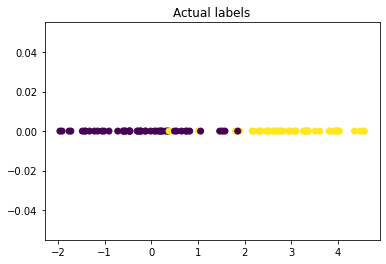

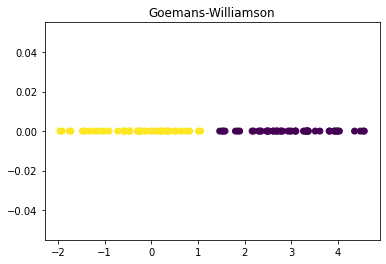

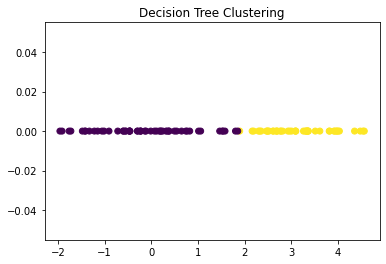

In [ ]:
# 1 dimension
X_1d, y_1d = get_dataset(1)
y_1d_gw = goemans_williamson(X_1d)
y_1d_dt = decision_tree(X_1d, y_1d)

plot(X_1d, y_1d, 'Actual labels')
plot(X_1d, y_1d_gw, 'Goemans-Williamson')
plot(X_1d, y_1d_dt, 'Decision Tree Clustering')

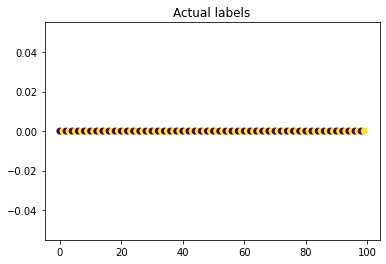

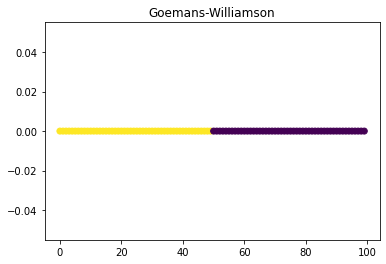

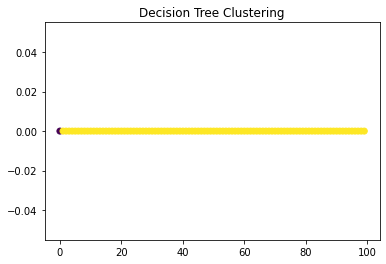

In [ ]:
# 1 dimension
X_1dC, y_1dC = get_concave_dataset(1, 100)
y_1dC_gw = goemans_williamson(X_1dC)
y_1dC_dt = decision_tree(X_1dC, y_1dC)

plot(X_1dC, y_1dC, 'Actual labels')
plot(X_1dC, y_1dC_gw, 'Goemans-Williamson')
plot(X_1dC, y_1dC_dt, 'Decision Tree Clustering')

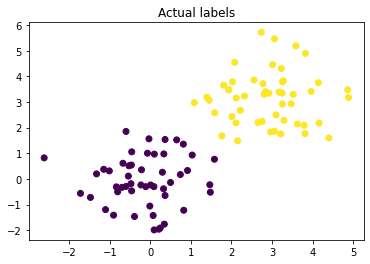

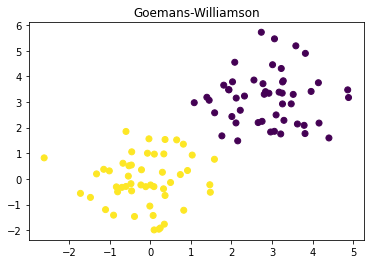

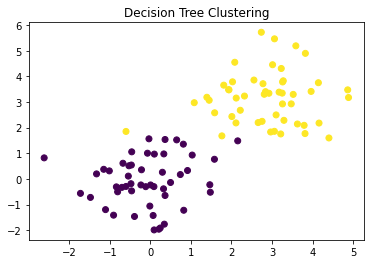

In [ ]:
# 2 dimensions
X_2d, y_2d = get_dataset(2)
y_2d_gw = goemans_williamson(X_2d)
y_2d_dt = decision_tree(X_2d, y_2d)

plot(X_2d, y_2d, 'Actual labels')
plot(X_2d, y_2d_gw, 'Goemans-Williamson')
plot(X_2d, y_2d_dt, 'Decision Tree Clustering')

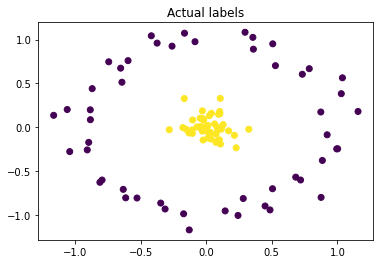

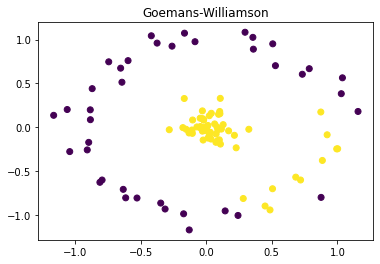

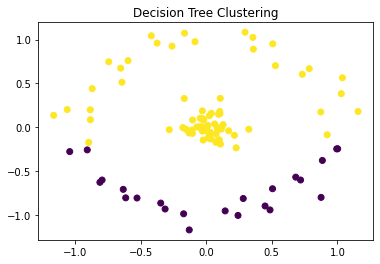

In [ ]:
# 2 dimension
X_2dC, y_2dC = get_concave_dataset(2, 100)
y_2dC_gw = goemans_williamson(X_2dC)
y_2dC_dt = decision_tree(X_2dC, y_2dC)

plot(X_2dC, y_2dC, 'Actual labels')
plot(X_2dC, y_2dC_gw, 'Goemans-Williamson')
plot(X_2dC, y_2dC_dt, 'Decision Tree Clustering')

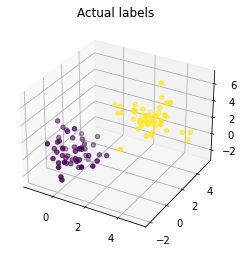

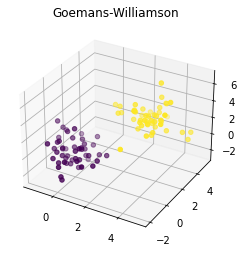

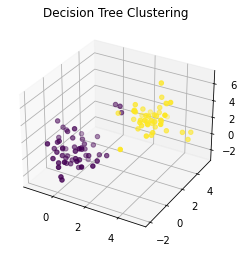

In [ ]:
# 3 dimensions
X_3d, y_3d = get_dataset(3)
y_3d_gw = goemans_williamson(X_3d)
y_3d_dt = decision_tree(X_3d, y_3d)

plot(X_3d, y_3d, 'Actual labels')
plot(X_3d, y_3d_gw, 'Goemans-Williamson')
plot(X_3d, y_3d_dt, 'Decision Tree Clustering')

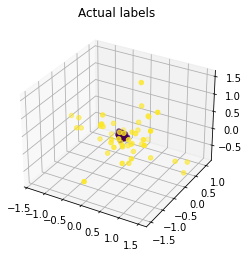

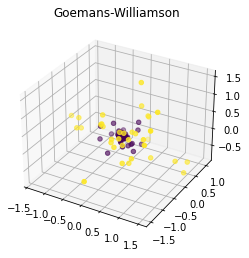

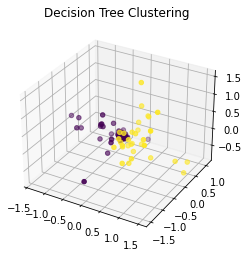

In [ ]:
# 3 dimension
X_3dC, y_3dC = get_concave_dataset(3, 100)
y_3dC_gw = goemans_williamson(X_3dC)
y_3dC_dt = decision_tree(X_3dC, y_3dC)

plot(X_3dC, y_3dC, 'Actual labels')
plot(X_3dC, y_3dC_gw, 'Goemans-Williamson')
plot(X_3dC, y_3dC_dt, 'Decision Tree Clustering')